In [1]:
# enviornment imports
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import AutoMinorLocator
import scipy.signal as sig
import scipy.stats as stat
# local imports
import DataAndPlotting as my
# paths
path_fig  = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\PHSX 616\\GitHub\PHSX616\\Lab3 - Torsional Oscillator\\Figures\\'
path_data = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\PHSX 616\\GitHub\PHSX616\\Lab3 - Torsional Oscillator\\Data\\'

# Data

In [2]:
# store files names for all datasets
filenames: dict[str,str] = {
   'Resonance Vpp=5'    : path_data + 'ResonanceVpp5.csv', 
   'Resonance Vpp=0.25' : path_data + 'ResonanceVpp025.csv', 
   'V1 Ain-Aout'        : path_data + 'V1VarVpp.csv', 
} # t==trial

tables: dict[str, dict[str, np.array]] = my.UnpackAllTables(filenames)

Resonance Vpp=5 columns:	 ['Freqency [mHz]', 'Max pk-pk [V]', 'Max Amplitude [V]']
Resonance Vpp=0.25 columns:	 ['Freqency [mHz]', 'Max pk-pk [V]', 'Max Amplitude [V]']
V1 Ain-Aout columns:	 ['input Amp. [V]', 'Output Amp. [V]']


# Plots

In [3]:
# https://coolors.co/f75c03-d90368-820263-3c6e71-04a777
# colors = ['#F75C03','#D90368','#820263','#3C6E71','#04A777']

# https://coolors.co/122354-317787-ad9c0b-b85300-782b38
colors = ['#122354','#317787','#AD9C0B','#B85300','#782B38']
colors_dark = [my.darken_color(c, 1.2) for c in colors]

In [4]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def BuildEquationStr(slope, intercept, slopeErr, intErr, roundto=1, yEqn='y') : 
    equn = str(yEqn)+' = ('+str(round(slope,roundto))+'$\pm$'+str(round(slopeErr,roundto))+')x' # y = (m+/-err)x
    if(intercept > 0) : 
        equn += ' + ('+str(my_ceil(intercept,roundto))+'$\pm$'+str(my_ceil(intErr,roundto))+')' # y = (m+/-err)x + (b+/-err)
    elif(intercept < 0) : 
        equn += ' - ('+str(my_ceil(abs(intercept),roundto))+'$\pm$'+str(my_ceil(intErr,roundto))+')' # y = (m+/-err)x - (b+/-err)
    return equn

def ymxb(x,slope,intercept):
    return (slope*x + intercept)

def AxDrawFit(ax,slope,intercept, xmin=10.0, xmax=40.0) : 
    x = [xmin,xmax]
    y = [ymxb(xmin,slope,intercept), ymxb(xmax,slope,intercept)]
    ax.plot(x,y, c=colors[4], linestyle='--')
    
def LeastSquareFit(ax,x,y,eqnPos='TL',xmin=10.0,xmax=40.0, append='') : 
    # least sequare fit
    result = stat.linregress(x,y)
    equn = BuildEquationStr(result.slope, result.intercept, result.stderr, result.intercept_stderr, yEqn='y$'+str(append)+'$')
    # build array of expected y
    y_exp = []
    for xi in x :
        y_exp.append(ymxb(xi,result.slope,result.intercept))
    # chi squared test
    chi2, pvalue = stat.chisquare(f_obs=y,f_exp=y_exp)
    chi2eqn = '$\chi^2'+str(append)+'$='+str(round(chi2,2))
    # add quation to plot 
    if(eqnPos=='BL') : 
        my.AxTextBL(ax,equn)
        my.AxTextBBL(ax, chi2eqn)
    elif(eqnPos=='TL') : 
        my.AxTextTL(ax,equn)
        my.AxTextTTL(ax, chi2eqn)
    # draw fit line
    AxDrawFit(ax,result.slope,result.intercept,xmin=xmin, xmax=xmax)

## Resonance

In [5]:
# https://stackoverflow.com/questions/49100778/fwhm-calculation-using-python 
def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

In [6]:
def plotFWHM(ax,x,y,c) : 
    ypos = max(y)/2.0
    x1,x2 = half_max_x(x,y)
    fwhm = x2-x1
    # add to axis 
    ax.plot([x1,x2], [ypos,ypos], c=c, linestyle='--', alpha=0.5)
    # finish 
    print("FWHM:\t{:.3f}".format(fwhm))
    return fwhm

def plotPeak(ax, x, y, c) : 
    peaky = max(y)
    peakx = x [ np.where(y == peaky) [0][0] ]
    # add to axis 
    ax.axvline(peakx, c=c, linestyle='--', alpha=0.5)
    # finish
    print('Resonance:\t', peakx, peaky)
    return (peakx, peaky)

In [7]:
def PlotXmanyY_peakFWHM(
    x: list[np.array], # x axis data points
    y: list[np.array], # y axis data points
    yleg : list[str], # legend lables 
    c : list, # colors
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    logScale: bool = False,
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.grid()
    if(logScale) : ax.set_yscale('log')
    qs = []
    # data
    for xi,yi,yl,ci in zip(x,y,yleg,c) : 
        print('==', yl, '==')
        cid = my.darken_color(ci,1.1)
        fwhm  = plotFWHM(ax,xi,yi,cid)
        px,py = plotPeak(ax,xi,yi,cid)
        q = (py/fwhm)
        print('Q:\t', q)
        qs.append(q)
        plt.errorbar(xi, yi, yerr=yerr, xerr=xerr, elinewidth=0.8, c=ci, linestyle=linestyle, linewidth=0.5, label=yl)
    if( yleg[0] != None) : plt.legend()
    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()
    return qs

== $A_{waveform}$ = 2.5 V ==
FWHM:	63.308
Resonance:	 862.0 24.0
Q:	 0.37909738717339697
== $A_{waveform}$ = 1.125 V ==
FWHM:	6.198
Resonance:	 864.0 11.1
Q:	 1.7910392609699681


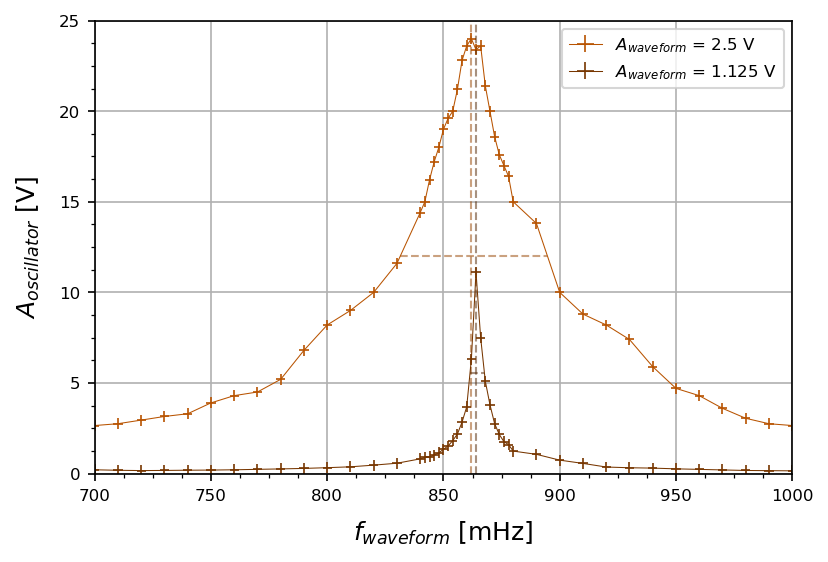

In [8]:
qs = PlotXmanyY_peakFWHM(
    x = [tables['Resonance Vpp=5']['Freqency [mHz]'],
         tables['Resonance Vpp=0.25']['Freqency [mHz]']],
    y  = [tables['Resonance Vpp=5']['Max Amplitude [V]'],
          tables['Resonance Vpp=0.25']['Max Amplitude [V]']],
    yleg = ['$A_{waveform}$ = 2.5 V', '$A_{waveform}$ = 1.125 V'],  
    c =[colors[3],colors_dark[3]],
    xerr = 2,    # error on x axis
    yerr = 0.3,    # error on y axis
    xlim = (700,1000),
    ylim = (0,25),
    xlab = '$f_{waveform}$ [mHz]', # label on x axis 
    ylab = '$A_{oscillator}$ [V]', # label on y axis
    linestyle = '-',   # style of xy curve line
    fileName = path_fig+'resonance_VvsF_vline.png'  # filename to save the figure as
) 

## $v^1$

In [12]:
def PlotXmanyY_LinearFit(
    x: np.array, # x axis data points
    y: list[np.array], # y axis data points
    yleg : list[str], # legend lables 
    c : list, # colors
    xmaxFit: float = 0.2, # make linear fit below this value of x
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    vlines: list = None, 
    hlines: list = None, 
    logScale: bool = False,
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.grid()
    if(logScale) : ax.set_yscale('log')
    # plot lines 
    if(vlines != None) : 
        for v in vlines : 
            plt.axvline(v, c=colors[4], linestyle=':')
    if(hlines != None) : 
        for h in hlines : 
            plt.axhline(h, c=colors[4], linestyle=':')
    # data
    for yi,yl,ci in zip(y,yleg,c) : 
        plt.errorbar(x, yi, yerr=yerr, xerr=xerr, elinewidth=0.8, c=ci, linestyle=linestyle, linewidth=0.5, label=yl)
    if( yleg[0] != None) : plt.legend()

    # fit 
    line = x < xmaxFit
    LeastSquareFit(plt.gca(), x[line], y[0][line], xmin=x[0]-1, xmax=x[-1]+1, append='_{x<'+str(my_ceil(xmaxFit,1))+'}') 
    
    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()

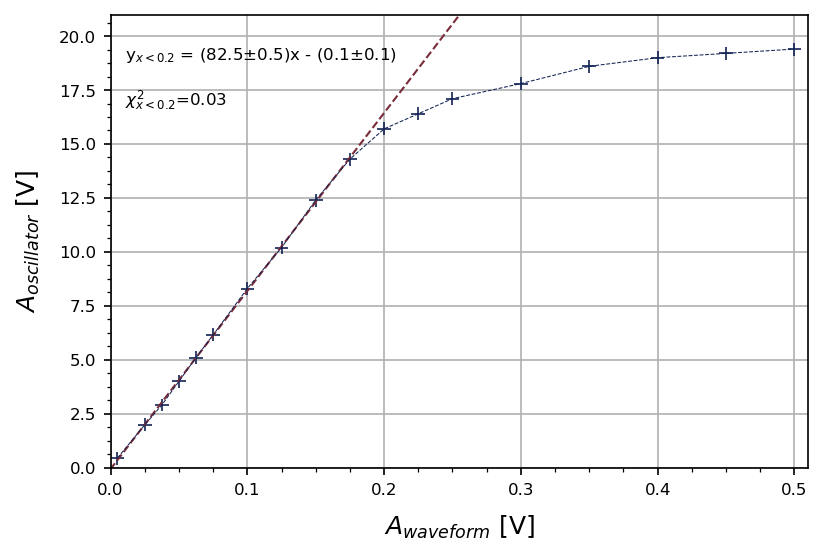

In [14]:
PlotXmanyY_LinearFit(
    x = tables['V1 Ain-Aout']['input Amp. [V]'],
    y  = [tables['V1 Ain-Aout']['Output Amp. [V]']],
    yleg = [None],  
    c =[colors[0]],
    xerr = 0.005,    # error on x axis
    yerr = 0.3,    # error on y axis
    xlim = (0,.51),
    ylim=(0,21),
    xlab = '$A_{waveform}$ [V]', # label on x axis 
    ylab = '$A_{oscillator}$ [V]', # label on y axis
    linestyle = '--',   # style of xy curve line
    fileName = path_fig+'v1_AinAout_linearFit.png'  # filename to save the figure as
) 